# Walkthrough

This notebook demonstrates how we used the EmergentPeriodicity (https://github.com/peleg-lab/EmergentPeriodicity) GitHub repo to replicate the simulations and plots used for the paper that our project was focused on. It then goes on to show how we adjusted the code to generate variations of the simulation for our project. It should also be noted that along the way we had to make adjustments in Firefly.py, run.py, simulation_helpers.py and Simulations.py files. However, we simply copied those files into this repo direct from the original GH repo. The main reason they are included is the pickled objects require some of these files to be read.

In [1]:
import os
import sys
import joypy
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import colormaps
from scipy.stats import ks_2samp
from scipy.signal import find_peaks

### Simulations Replication

The repo included a run.py file that allowed run to run the simulations using the command line. The simulations were computationally expensive, so the repo had implemented multiprocessing to run the simulations in parallel. To utilize this multiprocessing, we coded up a solution that would execute a command statement. Even with this approach, it took approximately 30 hours to replicate the simulations in the paper and an additionally simulation of 40 fireflies. The code we used to do this can be observed below.

In [ ]:
N = ['5', '10', '15', '20', '40', '100']
betas = [str(round(i * 0.01, 2)) for i in range(101)]

for n in N:
    if n == '5':
        folder = 'recreate/0' + n + 'ff'
    else:
        folder = 'recreate/' + n + 'ff'
    for beta in betas:
        command = 'python run.py -n ' + n + ' -s 200000 -l 16 -t 10 -b ' + beta + ' --time_step_size 0.009 --use_linear --no_refrac --one_flash --folder ' + folder
        os.system(command)

As can be seen in the command variable, there are a number of arguments that are passed. The arguments that we used that were important were:

- n - the number of fireflies
- s - the number of steps in the simulation
- t - the number of simulations
- b - the beta value
- time_step_size - the time in seconds that each step represented


The number of simulations was set to 200,000 and the time step size was set to 0.009 to replicate the original paper and how it expressed the simulations represented 30 minutes of real time. We also set the number of simulations to 10 to replicate the original paper. Then, there we four other arguments that weren't obvious from the original paper. They largely seemed to be made with the intend to investigate further, but don't seem to have been utilized for the paper. They include:

- l - the length, which was apparently not used in the code
- use_linear - made the numerator 1 in the differential equation. Without, the numerator would be log(2).
- no_refrac - without this, the could would subtract the minimum value from the envelope from the draw from the envelope
- one_flash - without this, the number of flashes per burst would be randomly drawn from [2,6] with a particular discrete distribution. However, the original paper only kept this at 1, so we did as well.

### Calculating Interburst Interval

Once all of the data was simulated, the next step was to calculate the interburst interval. No guidance on how this was done in the original paper was given, so it took some exploration. For each simulation, an array of firefly objects were returned that had epsilon values (firefly_array[i].epsilon) and flashed at value (firefly_array[i].flashed_at_this_step). There was also a built in function that returned the burst data from the Simulation object (Simulation.get_burst_data). We explored using the epsilon values to calculate the interburst data, but after comparison with using the flashed at value or the burst data (which returned the same values), it was determined that the original paper used the get_burst_data function. It should also be noted that the original data considered intervals of less than 2 seconds interflash intervals and discarded them without adjusting the start ends of other intervals. Thus, we did the same in our calculations.Below is our implementation of using this approach:

In [2]:
def get_ibs(simulation, time_step_size=0.009):

    #Initialize values
    ibs = []
    current_time = 0.0
    last_time = 0.0

    #Get the burst data
    burst_data = simulation.get_burst_data().values()

    #Iterate through the burst data and calculate the interburst intervals
    for step in burst_data:
        current_time += time_step_size
        if step:
            diff = current_time - last_time
            if diff > 2.0:
                ibs.append(diff)
            last_time = current_time
            
    return ibs

Below, simulation data is read in and the burst data from the first simulation is obtained and displayed:

In [3]:
example_data = pd.read_pickle('./recreate/05ff/beta=0.00_agents=5_experiment_results.pickle')
example_burst_data = example_data[0].get_burst_data()
example_burst_data

{0: 0,
 1: 0,
 2: 0,
 3: 0,
 4: 0,
 5: 0,
 6: 0,
 7: 0,
 8: 0,
 9: 0,
 10: 0,
 11: 0,
 12: 0,
 13: 0,
 14: 0,
 15: 0,
 16: 0,
 17: 0,
 18: 0,
 19: 0,
 20: 0,
 21: 0,
 22: 0,
 23: 0,
 24: 0,
 25: 0,
 26: 0,
 27: 0,
 28: 0,
 29: 0,
 30: 0,
 31: 0,
 32: 0,
 33: 0,
 34: 0,
 35: 0,
 36: 0,
 37: 0,
 38: 0,
 39: 0,
 40: 0,
 41: 0,
 42: 0,
 43: 0,
 44: 0,
 45: 0,
 46: 0,
 47: 0,
 48: 0,
 49: 0,
 50: 0,
 51: 0,
 52: 0,
 53: 0,
 54: 0,
 55: 0,
 56: 0,
 57: 0,
 58: 0,
 59: 0,
 60: 0,
 61: 0,
 62: 0,
 63: 0,
 64: 0,
 65: 0,
 66: 0,
 67: 0,
 68: 0,
 69: 0,
 70: 0,
 71: 0,
 72: 0,
 73: 0,
 74: 0,
 75: 0,
 76: 0,
 77: 0,
 78: 0,
 79: 0,
 80: 0,
 81: 0,
 82: 0,
 83: 0,
 84: 0,
 85: 0,
 86: 0,
 87: 0,
 88: 0,
 89: 0,
 90: 0,
 91: 0,
 92: 0,
 93: 0,
 94: 0,
 95: 0,
 96: 0,
 97: 0,
 98: 0,
 99: 0,
 100: 0,
 101: 0,
 102: 0,
 103: 0,
 104: 0,
 105: 0,
 106: 0,
 107: 0,
 108: 0,
 109: 0,
 110: 0,
 111: 0,
 112: 0,
 113: 0,
 114: 0,
 115: 0,
 116: 0,
 117: 0,
 118: 0,
 119: 0,
 120: 0,
 121: 0,
 122: 0,
 12

Below, using the get_ibs function is demonstrated to show how the InterBurst intervals in Seconds (ibs) was calculated.

In [4]:
get_ibs(example_data[0])

[17.874000000000493,
 12.41100000000047,
 69.95700000000265,
 14.688000000000557,
 35.32499999996621,
 13.175999999979695,
 18.692999999971192,
 36.61199999994358,
 11.501999999982274,
 21.50999999996685,
 12.834000000007308,
 61.92000000010012,
 6.975000000011278,
 36.65700000005927,
 43.28100000006998,
 31.30200000005061,
 15.498000000025058,
 40.680000000065775,
 37.44900000006055,
 10.116000000016356,
 2.8170000000045547,
 3.798000000006141,
 6.714000000010856,
 16.065000000025975,
 128.7630000002082,
 45.306000000073254,
 14.733000000023821,
 54.918000000088796,
 12.5550000000203,
 24.525000000039654,
 8.181000000013228,
 3.897000000006301,
 43.83900000007088,
 34.54200000005585,
 56.84400000009191,
 24.813000000040006,
 28.773000000046522,
 21.49200000003475,
 75.36600000012186,
 32.949000000053275,
 74.41200000012032,
 55.19700000008925,
 41.31900000006681,
 8.631000000013955,
 62.67600000010134,
 8.730000000014115,
 45.108000000072934,
 27.315000000044165,
 14.040000000022701,


Additionally, since there were 10 simulations, we created a function to merge the ibs data into a single array. We would then use this array to produce our plots and calculate the Kolmogorov–Smirnov with the associated experimental data as done in the original paper.

In [5]:
def merge_ibs(data, time_step_size=0.009):
    ibs = []
    for sim in data:
        ibs.extend(get_ibs(sim, time_step_size))
    return ibs

In [6]:
merge_ibs(example_data)

[17.874000000000493,
 12.41100000000047,
 69.95700000000265,
 14.688000000000557,
 35.32499999996621,
 13.175999999979695,
 18.692999999971192,
 36.61199999994358,
 11.501999999982274,
 21.50999999996685,
 12.834000000007308,
 61.92000000010012,
 6.975000000011278,
 36.65700000005927,
 43.28100000006998,
 31.30200000005061,
 15.498000000025058,
 40.680000000065775,
 37.44900000006055,
 10.116000000016356,
 2.8170000000045547,
 3.798000000006141,
 6.714000000010856,
 16.065000000025975,
 128.7630000002082,
 45.306000000073254,
 14.733000000023821,
 54.918000000088796,
 12.5550000000203,
 24.525000000039654,
 8.181000000013228,
 3.897000000006301,
 43.83900000007088,
 34.54200000005585,
 56.84400000009191,
 24.813000000040006,
 28.773000000046522,
 21.49200000003475,
 75.36600000012186,
 32.949000000053275,
 74.41200000012032,
 55.19700000008925,
 41.31900000006681,
 8.631000000013955,
 62.67600000010134,
 8.730000000014115,
 45.108000000072934,
 27.315000000044165,
 14.040000000022701,


At this point, we had the simulation data and the ability to extract the ibs data from the simulation data.

### Plots

There were a number of plots that were included in the original paper. The figures that we wanted to replicate included figure 5 and 7. We wanted to do so because it was a way to validate that our command described earlier was correct since there was no explicit description of the command used to generate the simulations used for the original paper. The first plot we wanted to duplicate was figure 5, which was a joyplot or ridgeline plot. Essentially, this is a plot of distributions for several groups. We believe that if our joyplots matched (at least very closely) the joyplot presented in the original paper, then we could feel assured that we replicated the simulations as was done in the original paper. Below is an example of how we generated the joyplots in our paper using our simulated data:

In [7]:
def get_ibs_distribution(n):

    ibs_array = []

    if n == '5':
        base_path = 'recreate/05ff/'
    else:
        base_path = 'recreate/' + n + 'ff/'

    files = os.listdir(base_path)

    for ind, file in enumerate(files):
        if ind % 4 == 0 or ind == 0:
            path = base_path + file
            data = pd.read_pickle(path)
            ibs = merge_ibs(data)
            ibs_array.append(ibs)

    if max(ibs_array[0]) < 80.0:
        ibs_array[0].append(80.0)
    
    return ibs_array

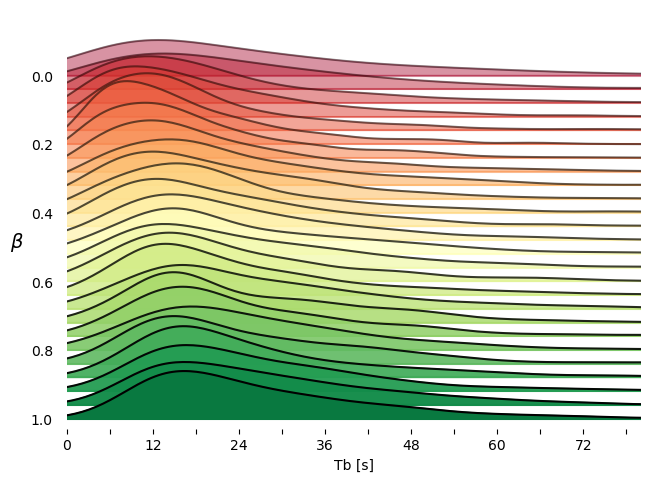

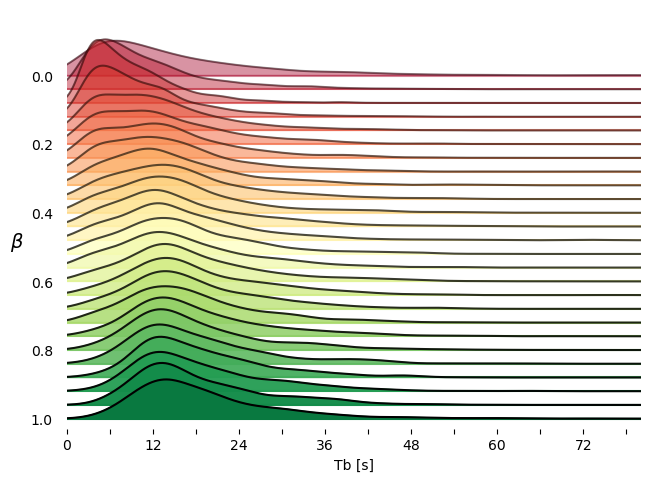

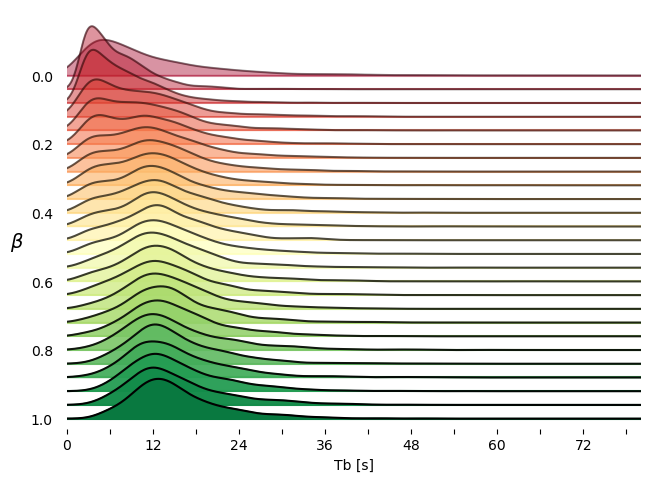

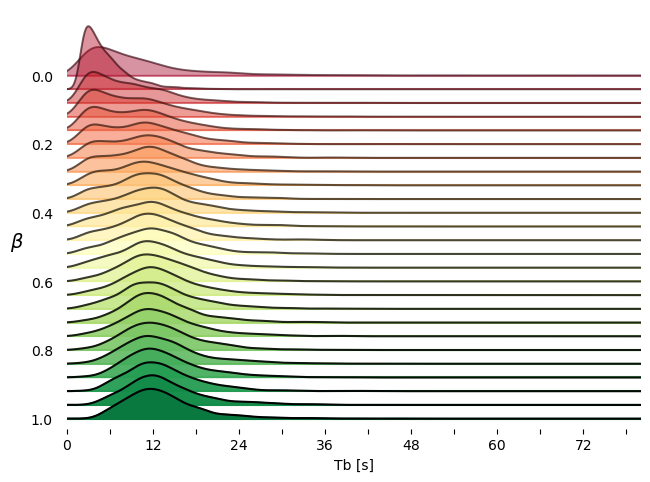

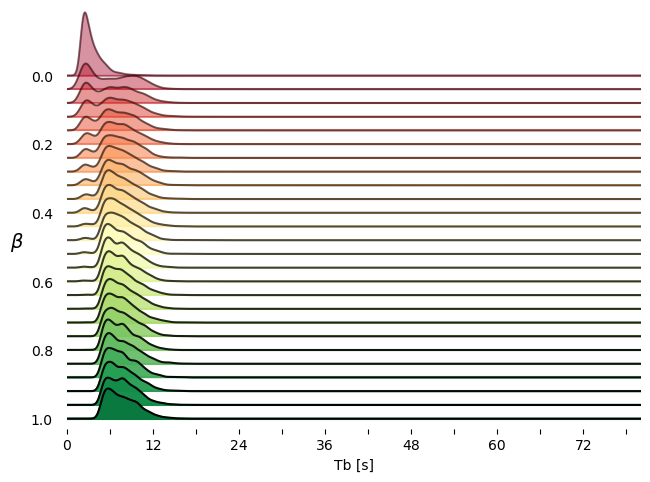

In [8]:
N = ['5', '10', '15', '20', '100']

x_labels = []
on = True
for i in range(0, 81, 6):
    if on:
        x_labels.append(str(i))
        on = False
    else:
        x_labels.append('')
        on = True

y_labels = []
for i in range(26):
    if i % 5 == 0:
        y_labels.append(str(round(i / 25, 2)))
    else:
        y_labels.append('')

for n in N:
    ibs_array = get_ibs_distribution(n)

    jfig, jaxes = joypy.joyplot(ibs_array, colormap=colormaps['RdYlGn'], fade=True, legend=True, bins=500, labels=y_labels)
    for jax in jaxes:
        jax.set_xlim(0.0, 80.0)

    jaxes[-1].set_xticks(np.arange(0.0, 80.0, 6.0), labels=x_labels)
    jaxes[-1].set_xlabel('Tb [s]')
    jaxes[15].set_ylabel('$\\beta$', rotation=0, labelpad=10, fontsize=14)
    jfig.savefig('recreate/N=' + n + '_joyplot.png', dpi=300, bbox_inches='tight')

The second plot that we wanted to recreate was Figure 7, which was the two-sided Kolgomorov-Smirnov test results between the simulation results and experimental results at each $\beta$ and for each $N$. We experimented for a while trying to decided how to recreate this plots. As can be seen in Figure 7 of the original paper, the KS tests results were as high as 20 or so. We figured that this was because they were using the test statistic location instead of the test statistic, which is a probability. We decided to use the test statistic because we felt that it was a better comparison between different $N$ values and also because the general shape of the graph seemed to match the original paper. Furthermore, when we tried to use the test statistic location, the values bounced around a lot and were not representative of the original paper. 

In [9]:
N = ['5', '10', '15', '20']

ks_values = {}

for n in N:

    ks_values[n] = []
    
    if n == '5':
        base_path = 'recreate/05ff/'
        compare_path = 'experimental_data/experimental/ibs05ff.csv'
    else:
        base_path = 'recreate/' + n + 'ff/'
        compare_path = 'experimental_data/experimental/ibs' + n + 'ff.csv'

    files = os.listdir(base_path)
    compare = pd.read_csv(compare_path)
    compare = compare['0'].values

    for file in files:
        path = base_path + file
        data = pd.read_pickle(path)
        ibs = merge_ibs(data)
        ks_value = ks_2samp(ibs, compare).statistic
        ks_values[n].append(ks_value)

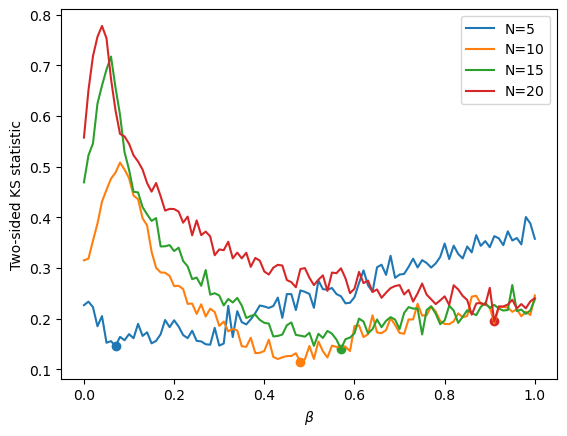

In [10]:
def get_min_values(ks_vals):
    ind = np.argmin(ks_vals)
    return ind / 100, ks_vals[ind]

N = ['5', '10', '15', '20']

for n in N:
    plt.plot([i / 100 for i in range(101)], ks_values[n], label='N=' + n)
    plt.scatter(*get_min_values(ks_values[n]))
    plt.xlabel('$\\beta$')
    plt.ylabel('Two-sided KS statistic')
    plt.legend()

plt.savefig('recreate/ks_values.png', dpi=300, bbox_inches='tight')
    

The minimum values were:

In [11]:
for n in N:
    beta, ks = get_min_values(ks_values[n])
    print('For ' + n + 'ff, the minimum KS statistic is ' + str(ks) + ' at beta=' + str(beta))

For 5ff, the minimum KS statistic is 0.14551724137931035 at beta=0.07
For 10ff, the minimum KS statistic is 0.1143545547215272 at beta=0.48
For 15ff, the minimum KS statistic is 0.1400476917718297 at beta=0.57
For 20ff, the minimum KS statistic is 0.19443236977468667 at beta=0.91


At this point, we also wanted to find the peaks of the distributions for the beta values where the KS statistic was minimized. 

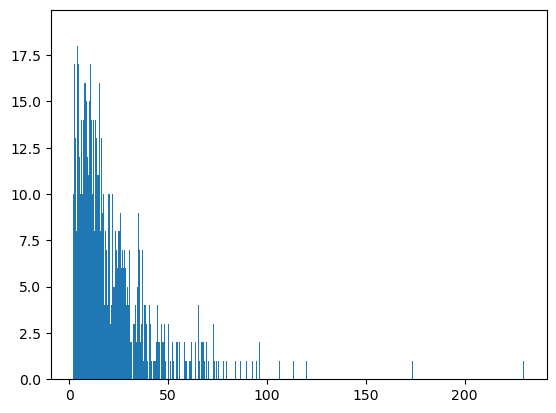

For 5ff, the peak of the histogram is 10.218456000016522


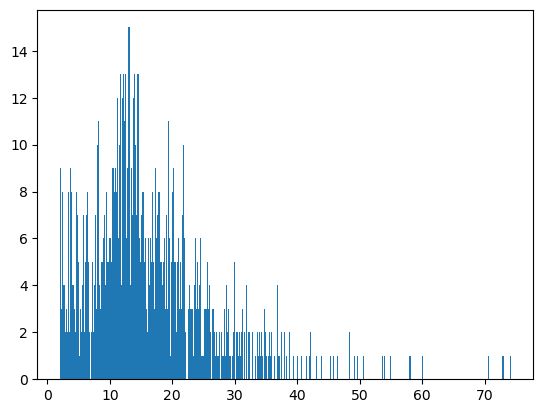

For 10ff, the peak of the histogram is 12.840750000020762


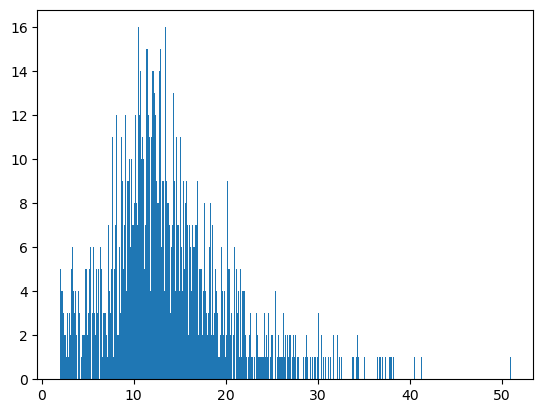

For 15ff, the peak of the histogram is 10.522908000017013


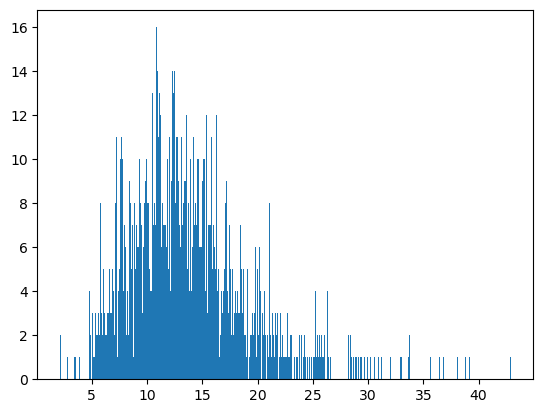

For 20ff, the peak of the histogram is 10.780055999988015


In [14]:
min_ks_dict = {'5': '0.07', '10': '0.48', '15': '0.57', '20': '0.91'}

for k, v in min_ks_dict.items():
    if k == '5':
        data = pd.read_pickle('recreate/0' + k + 'ff/beta=' + v + '_agents=' + k + '_experiment_results.pickle')
    else:
        data = pd.read_pickle('recreate/' + k + 'ff/beta=' + v + '_agents=' + k + '_experiment_results.pickle')
    ibs = merge_ibs(data)
    hist = np.histogram(ibs, bins=500)
    plt.hist(ibs, bins=500)
    plt.show()
    ind = np.argmax(hist[0])
    peak = hist[1][ind]
    print('For ' + k + 'ff, the peak of the histogram is ' + str(peak))


### Tweaking the Model

We attempted to tweak the model in a variaties of ways including randomizing the fireflies location and use a distance threshold to determine whether they were connected or not, multplying the Tb values from the original disribution and using a constant value for the Tb value to investigate the effect of reduced stochasticity. For the first part, we modified the code use an an adjacency matrix we generated at the beginning of each simulation. The adjacency matrix was generated with the following code:

In [15]:
def gen_adj_matrix(self):

        num_fireflies = 20
        grid_size = 10

        adj_matrix = [[0] * num_fireflies for _ in range(num_fireflies)]
        def distance(firefly1, firefly2):
            x1, y1, z1 = firefly1
            x2, y2, z2 = firefly2
            return math.sqrt((x1 - x2)**2 + (y1 - y2)**2 + (z1 - z2)**2)

        firefly_positions = [(random.uniform(0, grid_size), random.uniform(0, grid_size), random.uniform(0, grid_size)) for _ in range(num_fireflies)]

        for i in range(num_fireflies):
            for j in range(i+1, num_fireflies):
                dist = distance(firefly_positions[i], firefly_positions[j])
                if dist <= self.thresh:  # CAN TWEAK THIS PARAMETER BASED ON WHAT WE DEEM FITTING
                    adj_matrix[i][j] = 1
                    adj_matrix[j][i] = 1

        return adj_matrix

We placed this function in the Simulation.py file and then passed the generated matrix to the look function and modified the code to the following:

In [16]:
def look(self, step, adj_matrix):
        """Find neighbors in line of sight. Set limited to true to explore varying the FoV.
        Options:
        1. All-to-all adjacency matrix.
        """

        neighbors = {}
        for i in range(0, len(self.firefly_array)):
            ff_i = self.firefly_array[i]
            neighbors[ff_i.number] = []
            for j in range(0, self.total_agents):
                if i == j:
                    # same agent
                    continue
                else:
                    ff_j = self.firefly_array[j]
                    if ff_j.flashed_at_this_step[step - 1] and adj_matrix[ff_i.number][ff_j.number] == 1:
                        neighbors[ff_i.number].append(ff_j)

        return neighbors

Then, after some more general tweaking of the code so we could pass the threshold argument, we used the following code to run simulations: 

In [ ]:
N = [5, 10, 15, 20]
thresholds = [2, 4, 6, 8, 10, 12]
for n in N:
    if n == 5:
        folder = '0' + str(n) + 'ff'
    else:
        folder = str(n) + 'ff'
    for thres in thresholds:
        command = 'python run.py -n ' + str(n) + ' -s 200000 -l 16 -t 10 -b 0.7 --time_step_size 0.009 --use_linear --no_refrac --one_flash --thresh ' + str(thres) + ' --folder ' + folder
        os.system(command)

Here the grid search parameter that we were invesigating was the distance threshold. With this data, we used the following code to produce joyplots to assess the effects:

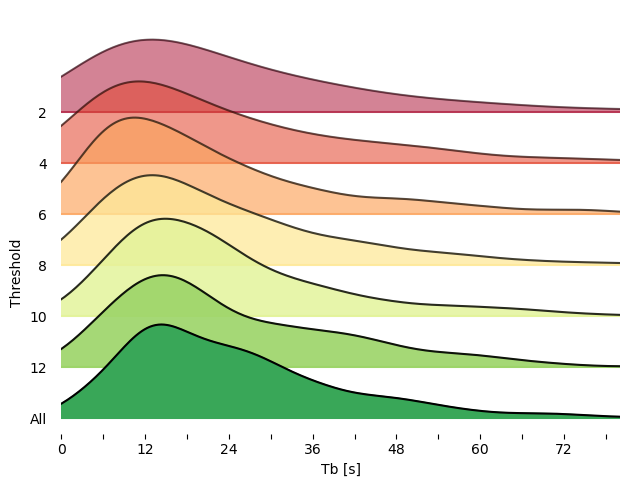

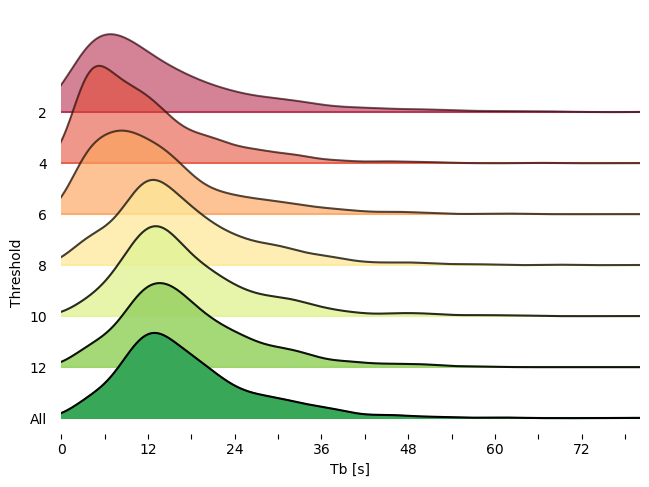

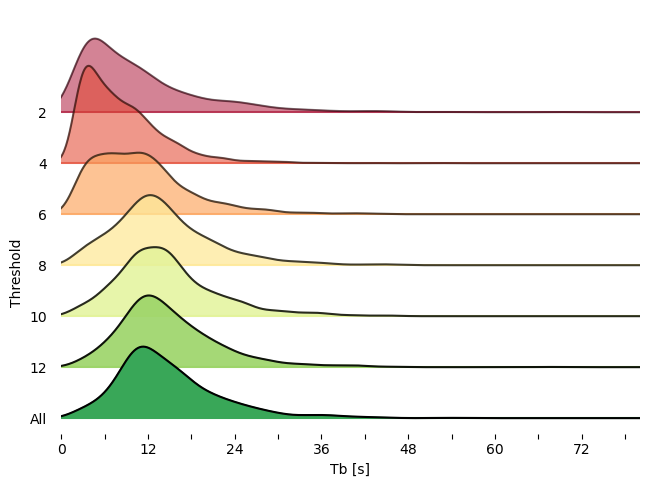

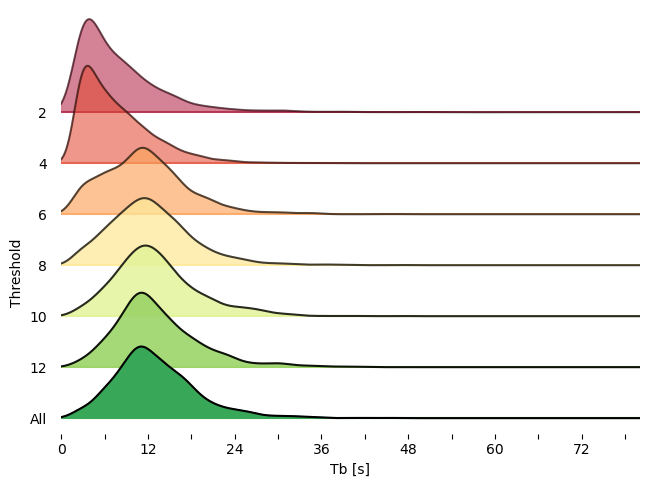

In [17]:
def get_ibs_distribution(n):

    ibs_array = []

    if n == '5':
        base_path = 'distance/05ff/'
    else:
        base_path = 'distance/' + n + 'ff/'

    files = os.listdir(base_path)

    for file in files:
        path = base_path + file
        data = pd.read_pickle(path)
        ibs = merge_ibs(data)
        ibs_array.append(ibs)

    if max(ibs_array[0]) < 80.0:
        ibs_array[0].append(80.0)
    
    return ibs_array

N = ['5', '10', '15', '20']

x_labels = []
on = True
for i in range(0, 81, 6):
    if on:
        x_labels.append(str(i))
        on = False
    else:
        x_labels.append('')
        on = True

y_labels = ['2', '4', '6', '8', '10', '12', 'All']

for n in N:
    ibs_array = get_ibs_distribution(n)

    jfig, jaxes = joypy.joyplot(ibs_array, colormap=colormaps['RdYlGn'], fade=True, legend=True, bins=500, labels=y_labels)
    for jax in jaxes:
        jax.set_xlim(0.0, 80.0)

    jaxes[-1].set_xticks(np.arange(0.0, 80.0, 6.0), labels=x_labels)
    jaxes[-1].set_xlabel('Tb [s]')
    jaxes[4].set_ylabel('Threshold')
    jfig.savefig('distance/N=' + n + '_beta=0.7joyplot.png', dpi=300, bbox_inches='tight')

Additionally, we did the essentially the same thing, but instead of saying fireflies were connected if the distance was less than, we did it if the distance was greater than:

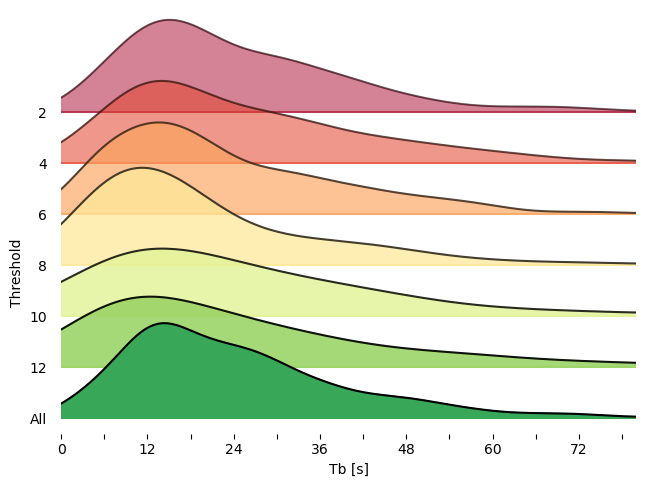

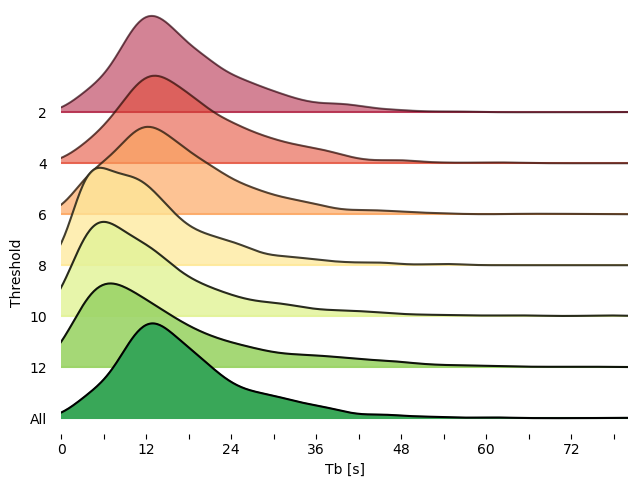

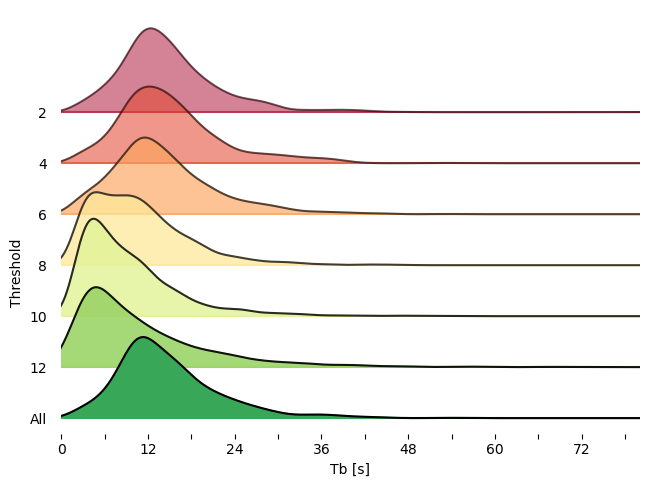

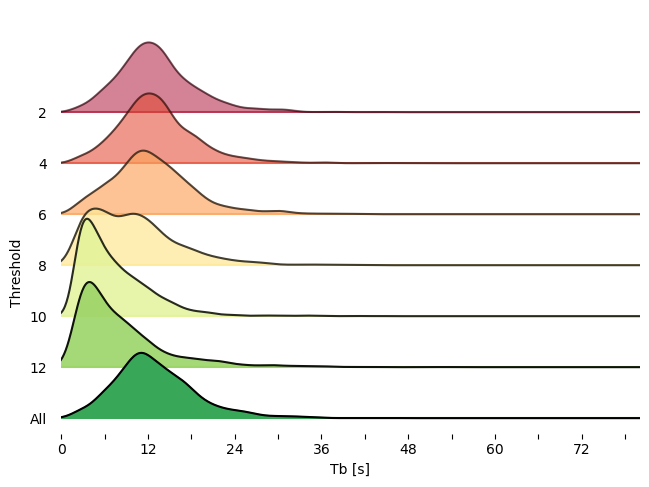

In [18]:
def get_ibs_distribution(n):

    ibs_array = []

    if n == '5':
        base_path = 'distance_reverse/05ff/'
    else:
        base_path = 'distance_reverse/' + n + 'ff/'

    files = os.listdir(base_path)

    for file in files:
        path = base_path + file
        data = pd.read_pickle(path)
        ibs = merge_ibs(data)
        ibs_array.append(ibs)

    if max(ibs_array[0]) < 80.0:
        ibs_array[0].append(80.0)
    
    return ibs_array

N = ['5', '10', '15', '20']

x_labels = []
on = True
for i in range(0, 81, 6):
    if on:
        x_labels.append(str(i))
        on = False
    else:
        x_labels.append('')
        on = True

y_labels = ['2', '4', '6', '8', '10', '12', 'All']

for n in N:
    ibs_array = get_ibs_distribution(n)

    jfig, jaxes = joypy.joyplot(ibs_array, colormap=colormaps['RdYlGn'], fade=True, legend=True, bins=500, labels=y_labels)
    for jax in jaxes:
        jax.set_xlim(0.0, 80.0)

    jaxes[-1].set_xticks(np.arange(0.0, 80.0, 6.0), labels=x_labels)
    jaxes[-1].set_xlabel('Tb [s]')
    jaxes[4].set_ylabel('Threshold')
    jfig.savefig('distance_reverse/N=' + n + '_beta=0.7joyplot.png', dpi=300, bbox_inches='tight')

The next main thing we did was experiment if we multiplied the values of the Tb envelope distribution by a scaler value. This was done by adjusting the following function in the simulation_helpers.py file and adjusting the rest of the code to pass the mult parameter:

In [19]:
def draw_from_input_distribution(num_draws, mult):
    with open('experimental_data/experimental/envelope_01ff.csv', newline='') as f:
        reader = csv.reader(f)
        data = list(reader)

    X_NICE = [float(d[0]) * mult for d in data]
    Y_NICE = [float(d[1]) for d in data]
    Tc_input = numpy.random.choice(X_NICE, num_draws, p=Y_NICE)
    return Tc_input

Then, we conducted another grid search over multiple values that we multiplied the distribution values by. This produced the following graphs:

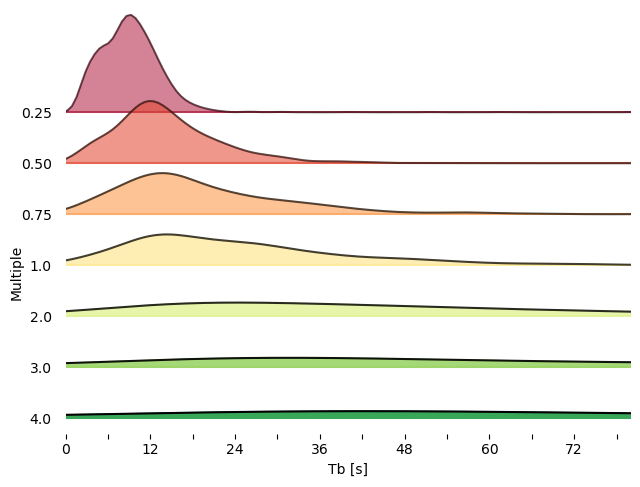

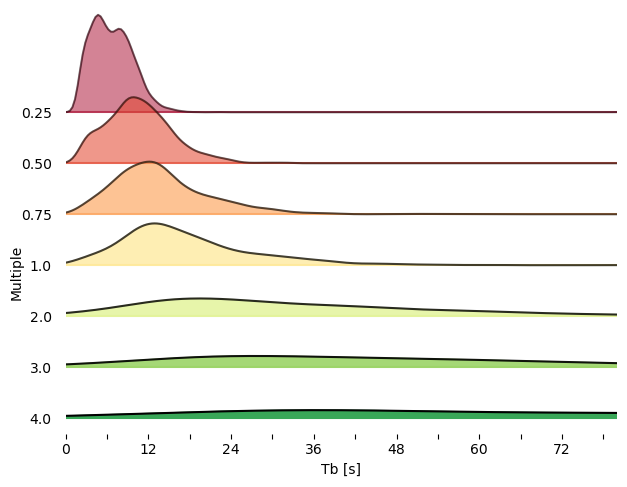

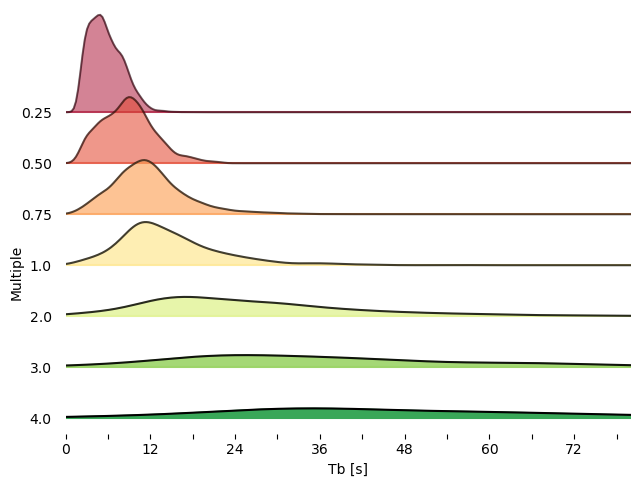

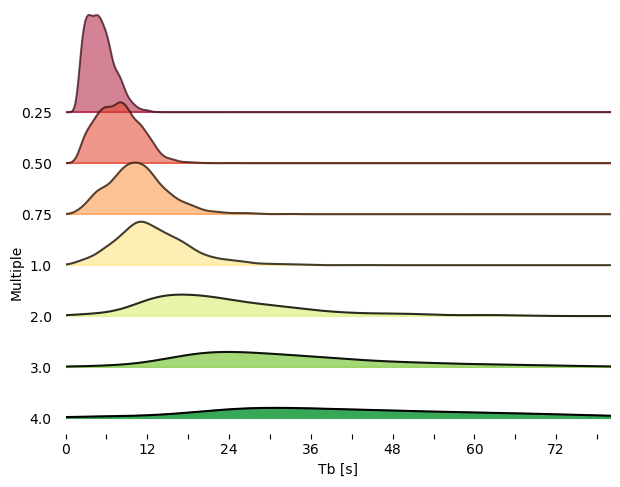

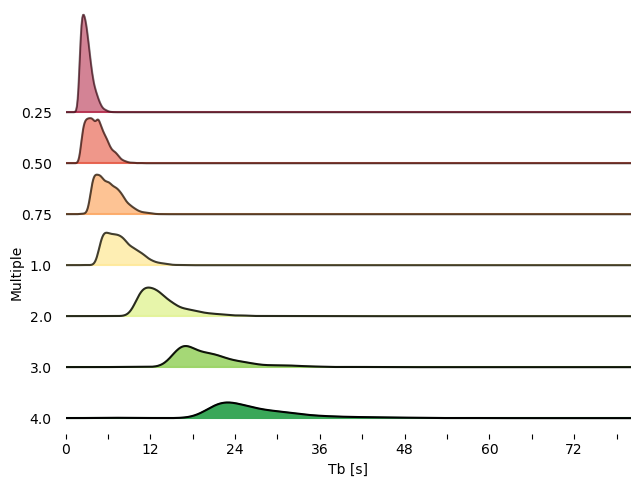

In [20]:
def get_ibs_distribution(n):

    ibs_array = []

    if n == '5':
        base_path = 'distribution_multiple/05ff/'
    else:
        base_path = 'distribution_multiple/' + n + 'ff/'

    files = os.listdir(base_path)

    for file in files:
        path = base_path + file
        data = pd.read_pickle(path)
        ibs = merge_ibs(data)
        ibs_array.append(ibs)

    if max(ibs_array[0]) < 80.0:
        ibs_array[0].append(80.0)
    
    return ibs_array

N = ['5', '10', '15', '20', '100']

x_labels = []
on = True
for i in range(0, 81, 6):
    if on:
        x_labels.append(str(i))
        on = False
    else:
        x_labels.append('')
        on = True

y_labels = ['0.25', '0.50', '0.75', '1.0', '2.0', '3.0', '4.0']

for n in N:
    ibs_array = get_ibs_distribution(n)

    jfig, jaxes = joypy.joyplot(ibs_array, colormap=colormaps['RdYlGn'], fade=True, legend=True, bins=500, labels=y_labels)
    for jax in jaxes:
        jax.set_xlim(0.0, 80.0)

    jaxes[-1].set_xticks(np.arange(0.0, 80.0, 6.0), labels=x_labels)
    jaxes[-1].set_xlabel('Tb [s]')
    jaxes[4].set_ylabel('Multiple')
    jfig.savefig('distribution_multiple/N=' + n + '_beta=0.7joyplot.png', dpi=300, bbox_inches='tight')

Then, the last modification we did was that instead of drawing from the envelope for a value of Tb, we used a fixed value. Here, we again adjusted the simulation_helpers.py file, but just would return a fixed value. In the code example below we returned 300:

In [21]:
def draw_from_input_distribution(num_draws):
    with open('experimental_data/experimental/envelope_01ff.csv', newline='') as f:
        reader = csv.reader(f)
        data = list(reader)

    X_NICE = [float(d[0]) for d in data]
    Y_NICE = [float(d[1]) for d in data]
    Tc_input = numpy.random.choice(X_NICE, num_draws, p=Y_NICE)
    #return Tc_input
    return 300.0

Then, we conducted another grid search over beta for 10 fireflies and fixed values of 5, 40, and 300. This produced the following graphs:

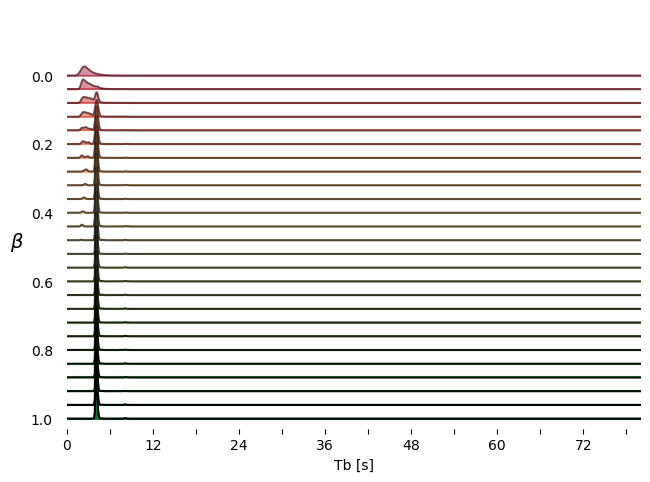

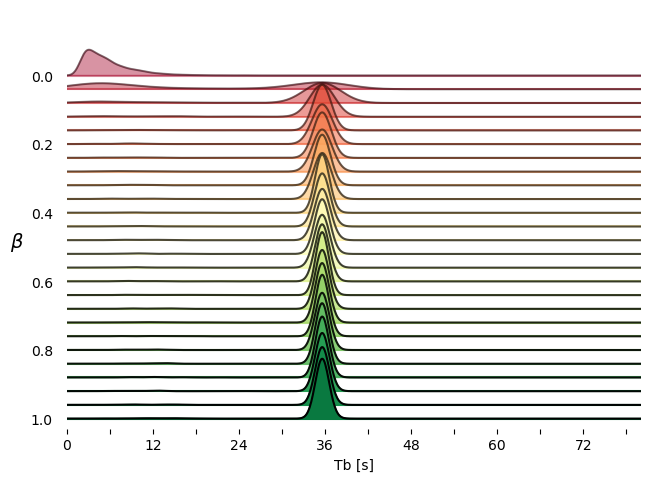

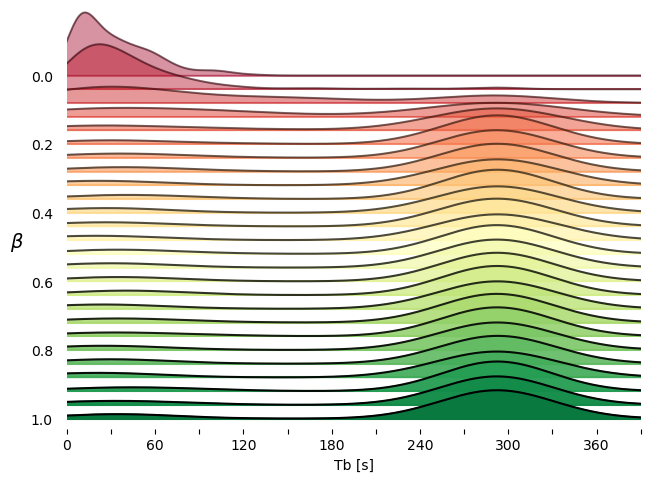

In [22]:
def get_ibs_distribution(n):

    ibs_array = []

    base_path = 'fixed_draw/10ff' + n + '/'

    files = os.listdir(base_path)

    for file in files:
        path = base_path + file
        data = pd.read_pickle(path)
        ibs = merge_ibs(data)
        ibs_array.append(ibs)

    if n == '300':
        max_val = 400.0
    else:
        max_val = 80.0

    if max(ibs_array[0]) < max_val:
        ibs_array[0].append(max_val)
    
    return ibs_array, max_val

N = ['5', '40', '300']

x_labels = []
on = True
for i in range(0, 81, 6):
    if on:
        x_labels.append(str(i))
        on = False
    else:
        x_labels.append('')
        on = True

y_labels = []
for i in range(26):
    if i % 5 == 0:
        y_labels.append(str(round(i / 25, 2)))
    else:
        y_labels.append('')

for n in N:
    ibs_array, max_val = get_ibs_distribution(n)

    if max_val == 400.0:
        max_val = 360.0

    jfig, jaxes = joypy.joyplot(ibs_array, colormap=colormaps['RdYlGn'], fade=True, legend=True, bins=500, labels=y_labels)
    for jax in jaxes:
        jax.set_xlim(0.0, max_val)

    if max_val == 80.0:
        steps = 6.0
    else:
        max_val = 400
        steps = 30.0
        x_labels = []
        on = True
        for i in range(0, 401, 30):
            if on:
                x_labels.append(str(i))
                on = False
            else:
                x_labels.append('')
                on = True

    jaxes[-1].set_xticks(np.arange(0.0, max_val, steps), labels=x_labels)
    jaxes[-1].set_xlabel('Tb [s]')
    jaxes[15].set_ylabel('$\\beta$', rotation=0, labelpad=10, fontsize=14)
    jfig.savefig('fixed_draw/' + n + '_joyplot.png', dpi=300, bbox_inches='tight')

Then, we also decided to grid search over values of $\beta$ for 10 fireflies with the distance threshold we used before. We used the previously shown code, and were able to generate the following plots:

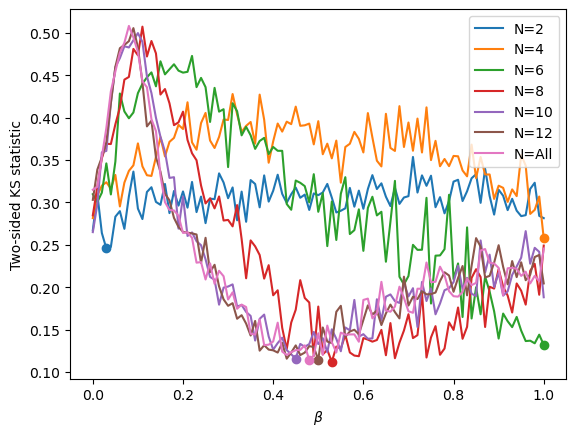

In [106]:
N = ['2', '4', '6', '8', '10', '12', 'All']

ks_values = {}

compare_path = 'experimental_data/experimental/ibs10ff.csv'
compare = pd.read_csv(compare_path)
compare = compare['0'].values

for n in N:

    ks_values[n] = []
    
    base_path = 'distance/10ff' + n + '/'

    files = os.listdir(base_path)

    for file in files:
        path = base_path + file
        data = pd.read_pickle(path)
        ibs = merge_ibs(data)
        ks_value = ks_2samp(ibs, compare).statistic
        ks_values[n].append(ks_value)

for n in N:
    plt.plot([i / 100 for i in range(101)], ks_values[n], label='N=' + n)
    plt.scatter(*get_min_values(ks_values[n]))
    plt.xlabel('$\\beta$')
    plt.ylabel('Two-sided KS statistic')
    plt.legend()

plt.savefig('distance/ks_values.png', dpi=300, bbox_inches='tight')

The minimum values were:

In [107]:
for n in N:
    beta, ks = get_min_values(ks_values[n])
    print('For a threshold of ' + n + ', the minimum KS statistic is ' + str(ks) + ' at beta=' + str(beta))

For a threshold of 2, the minimum KS statistic is 0.24570459074669204 at beta=0.03
For a threshold of 4, the minimum KS statistic is 0.2576886774644165 at beta=1.0
For a threshold of 6, the minimum KS statistic is 0.13208044405646238 at beta=1.0
For a threshold of 8, the minimum KS statistic is 0.11198959084392067 at beta=0.53
For a threshold of 10, the minimum KS statistic is 0.115878616796048 at beta=0.45
For a threshold of 12, the minimum KS statistic is 0.11461976447530708 at beta=0.5
For a threshold of All, the minimum KS statistic is 0.1143545547215272 at beta=0.48


At this point, we also wanted to find the peaks of the distributions for the beta values where the KS statistic was minimized. 

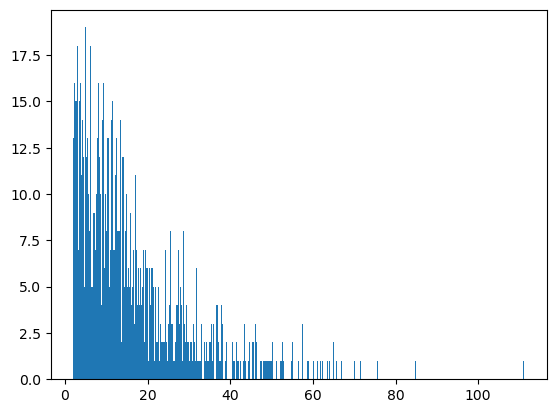

For a threshold of 2, the peak of the histogram is 4.844016000007832


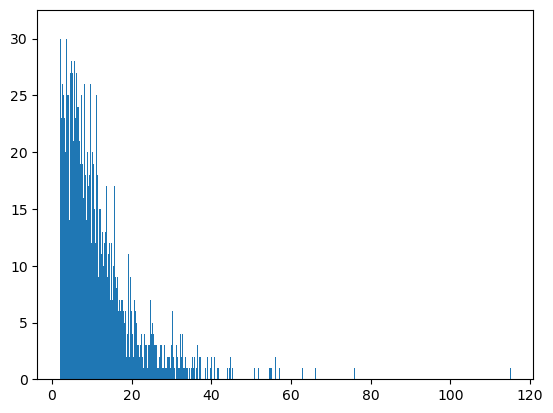

For a threshold of 4, the peak of the histogram is 3.138660000001938


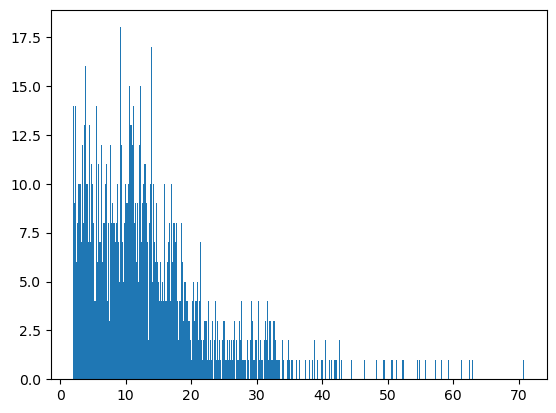

For a threshold of 6, the peak of the histogram is 9.17546400000913


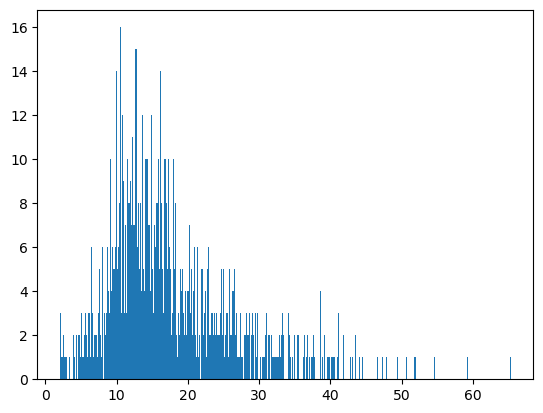

For a threshold of 8, the peak of the histogram is 10.54576800001705


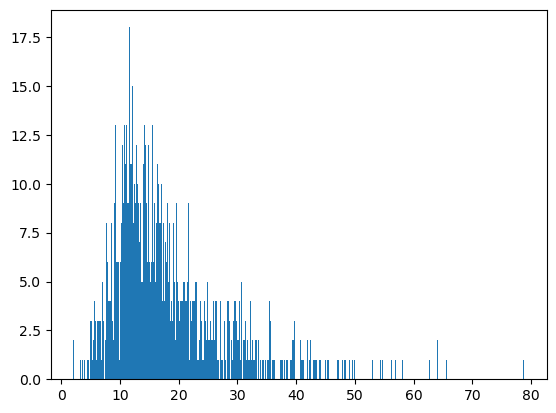

For a threshold of 10, the peak of the histogram is 11.556828000018685


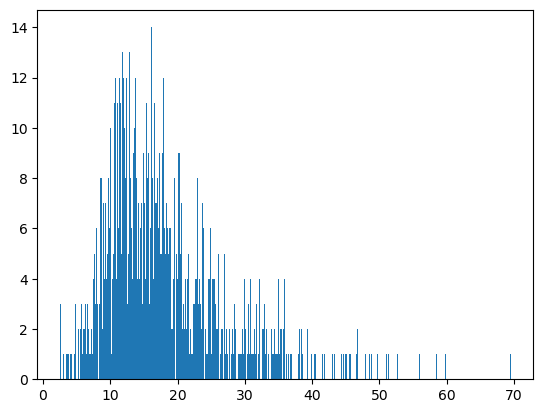

For a threshold of 12, the peak of the histogram is 16.076556000025995


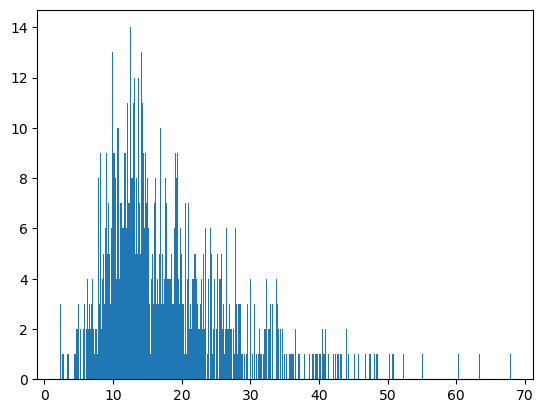

For a threshold of All, the peak of the histogram is 12.514392000017212


In [26]:
min_ks_dict = {'2': '0.07', '4': '0.48', '6': '0.57', '8': '0.91', '10': '0.91', '12': '0.91', 'All': '0.91'}

for k, v in min_ks_dict.items():
    if k == 'All':
        data = pd.read_pickle('distance/10ff' + k + '/beta=' + v + '_agents=10_experiment_results.pickle')
    else:
        data = pd.read_pickle('distance/10ff' + k + '/beta=' + v + '_agents=10_thresh=' + k + '_experiment_results.pickle')
    ibs = merge_ibs(data)
    hist = np.histogram(ibs, bins=500)
    plt.hist(ibs, bins=500)
    plt.show()
    ind = np.argmax(hist[0])
    peak = hist[1][ind]
    print('For a threshold of ' + k + ', the peak of the histogram is ' + str(peak))